# Human Activity Recognition Using Smartphones Data Set
dataset :- [link](http://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split 
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import torch
import sklearn
import random
import pickle

# EDA


In [4]:
x_train = pd.read_csv("X_train.txt" ,sep=" ",header=None)
y_train = pd.read_csv("Y_train.txt" ,sep=" ",header=None)
x_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,...,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000,9625.000000
mean,0.291343,-0.016835,-0.106462,-0.625414,-0.520405,-0.592169,-0.654177,-0.534447,-0.593144,-0.468789,...,0.130278,-0.294684,-0.616849,-0.007031,0.016464,0.011888,-0.007838,-0.504904,0.064257,-0.044264
std,0.211939,0.051584,0.087439,0.411760,0.476969,0.411925,0.386931,0.463681,0.411504,0.527211,...,0.242788,0.312505,0.301731,0.333153,0.448349,0.607592,0.494243,0.485622,0.282043,0.287950
min,-2.558400,-0.885720,-1.000000,-1.000100,-1.000000,-1.004100,-1.000000,-0.999914,-1.004100,-1.000000,...,-0.915866,-0.995357,-1.001000,-1.001000,-1.000000,-0.999790,-1.000000,-0.999380,-1.000000,-1.074400
25%,0.262162,-0.025655,-0.123320,-0.989887,-0.971939,-0.975275,-0.991221,-0.972508,-0.975098,-0.932965,...,-0.015497,-0.523810,-0.836211,-0.129056,-0.272020,-0.521850,-0.405568,-0.811218,-0.039047,-0.136269
50%,0.277462,-0.017099,-0.108561,-0.897170,-0.764680,-0.763690,-0.904706,-0.769180,-0.754986,-0.837091,...,0.141600,-0.331040,-0.700828,0.005181,0.016319,0.015205,-0.006230,-0.698196,0.145470,0.009167
75%,0.293911,-0.009470,-0.094664,-0.305880,-0.101923,-0.256996,-0.359966,-0.130190,-0.266197,-0.066055,...,0.291271,-0.109844,-0.486410,0.124890,0.310067,0.538710,0.391080,-0.505830,0.236764,0.134622
max,2.394500,0.769080,1.658900,1.000000,1.594100,2.041200,1.000000,1.864200,2.464300,2.243300,...,1.000000,0.942590,0.933850,1.000000,1.011600,1.000000,1.000000,1.000000,0.999761,0.999014


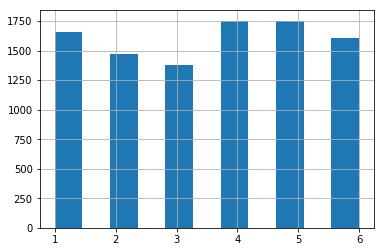

In [5]:
y_train[0].value_counts().plot.bar()

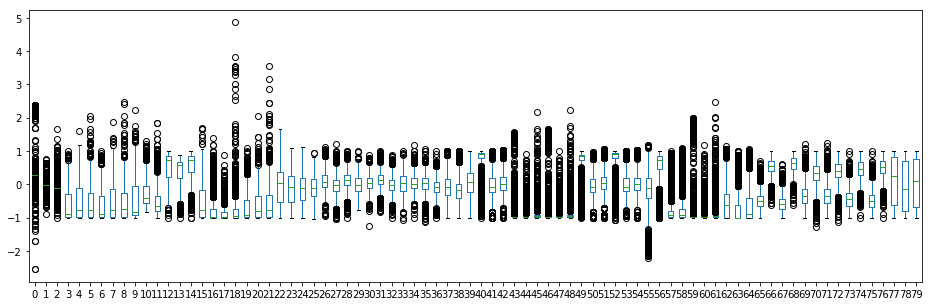

In [6]:
plot = x_train.iloc[:, :80].plot(kind='box', figsize=[16,5])
plt.show(plot)

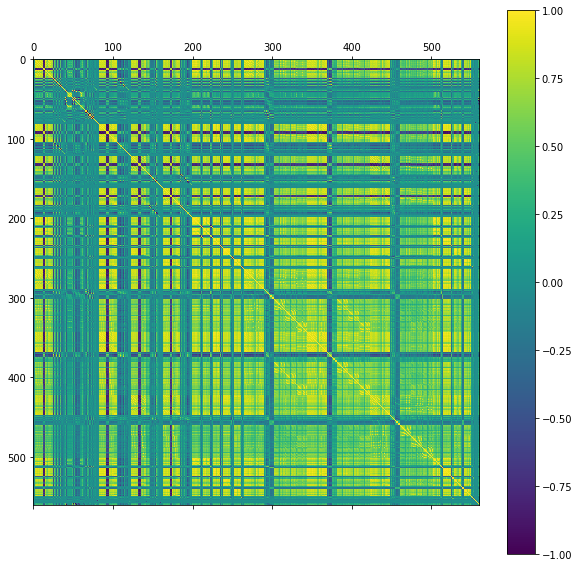

In [ ]:
# plot correlation matrix
correlations = x_train.corr()
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train.values, y_train.values, test_size=0.10, random_state=int(random.random()*100))
Y_train = (Y_train - 1).flatten()
Y_test = (Y_test - 1).flatten()
print(X_train.shape)
print(Y_train.shape)

(8662, 561)
(8662,)


# Neural Network



In [ ]:
X_trainc = torch.tensor(X_train,dtype=torch.float).cuda()
Y_trainc = torch.tensor(Y_train,dtype=torch.long).cuda() 
X_testc  = torch.tensor(X_test,dtype=torch.float).cuda()
Y_testc  = torch.tensor(Y_test,dtype=torch.long).cuda() 

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, 1000)
        self.linear2 = torch.nn.Linear(1000, 2000)
        self.linear3 = torch.nn.Linear(2000, D_out)
        self.drop1 = torch.nn.Dropout(p=0.45, inplace=False)
        self.drop2 = torch.nn.Dropout(p=0.45, inplace=False)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.drop1(x)
        x = self.relu(self.linear2(x))
        x = self.drop2(x)
        y_pred = self.linear3(x)
        return y_pred

In [ ]:
model = Net(561,6).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
step = torch.optim.lr_scheduler.StepLR(optimizer,100, gamma = 0.5, last_epoch=-1)

In [ ]:
def acc(model): #evaluates the models and prints accuracy
    model.eval()
    y = torch.argmax(model(X_testc),dim = 1)
    y = y.cpu().detach().numpy()
    x = np.equal(y, Y_testc.cpu().detach().numpy())
    sum = np.sum(x)
    print("Test accuracy is ",end=" ")
    print( (100 * sum) / y.shape[0], end= " ")
    y = torch.argmax(model(X_trainc),dim = 1)
    y = y.cpu().detach().numpy()
    x = np.equal(y, Y_trainc.cpu().detach().numpy())
    sum = np.sum(x)
    print("Train accuracy is ",end=" ")
    print( (100 * sum) / y.shape[0])

In [ ]:
model.train()
for i in range(1501):
    if i < 510: step.step()
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_trainc).cuda()
    loss = criterion(y_pred, Y_trainc)
    loss.backward()
    optimizer.step()
    if i%300 == 0: acc(model)

Test accuracy is  19.833852544132917 Train accuracy is  19.41814823366428
Test accuracy is  95.74247144340602 Train accuracy is  99.58439159547449
Test accuracy is  95.84631360332295 Train accuracy is  99.88455322096513
Test accuracy is  95.95015576323988 Train accuracy is  99.97691064419303
Test accuracy is  95.95015576323988 Train accuracy is  100.0
Test accuracy is  95.95015576323988 Train accuracy is  100.0


Our neural network achived around **96%** test accuracy.

# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, n_jobs = 4, random_state = 112)

rf.fit(X_train, Y_train);

predictions = rf.predict(X_test)

errors = np.count_nonzero(predictions - Y_test)

print('Mean Absolute accuracy:', ((Y_test.shape[0] - errors)/Y_test.shape[0] ) * 100 , '%')

Mean Absolute accuracy: 95.22326064382139 %


Our Random Forest Classifier  achived around **95.22%** test accuracy.


# SVM


In [ ]:
clf = SVC(decision_function_shape='ovo', gamma='scale', kernel='rbf', max_iter=2000 )

clf.fit(X_train, Y_train) 

y_pred = clf.predict(X_test)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(Y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.63%


Simple SVM got around **92.63%** accuracy

# XGBoost


**GRID SEARCH WITH CROSS VALIDATION**

In [ ]:
print("Grid Search for parameters")
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, {'max_depth': [4,5,6,7],'n_estimators': [50,100,150,200,250]}, verbose=1, n_jobs = 4,cv=cv)
clf.fit(X_train, Y_train)
print(clf.best_score_)
print(clf.best_params_)

Grid Search for parameters
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 34.3min finished


0.9658630876414802
{'max_depth': 7, 'n_estimators': 250}


**K Fold**

In [27]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_train):
    xgb_model = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, n_classes_ = 6, nthread=8).fit(X_train[train_index], Y_train[train_index]) 
    predictions = xgb_model.predict(X_train[test_index])
    actuals = Y_train[test_index]
    print("result on test part of KFolded dataset")
    print(confusion_matrix(actuals, predictions))
    predictions = [round(value) for value in predictions]
    accuracy = accuracy_score(actuals, predictions)
    print("Accuracy test: %.2f%%" % (accuracy * 100.0))
    
    print("result on full training dataset")
    predictions = xgb_model.predict(X_train)
    actuals = Y_train
    print(confusion_matrix(actuals, predictions))
    predictions = [round(value) for value in predictions]
    accuracy = accuracy_score(actuals, predictions)
    print("Accuracy full train: %.2f%%" % (accuracy * 100.0))
    
    print("result on full test dataset")
    predictions = xgb_model.predict(X_test)
    actuals = Y_test
    print(confusion_matrix(actuals, predictions))
    predictions = [round(value) for value in predictions]
    accuracy = accuracy_score(actuals, predictions)
    print("Accuracy full test: %.2f%%" % (accuracy * 100.0))

result on test part of KFolded dataset
[[488   7   8   0   0   0]
 [  5 428   2   0   0   5]
 [  6  13 389   1   1   1]
 [  0   2   0 495  25   5]
 [  0   0   2  22 493   0]
 [  0   2   0   1   0 487]]
Accuracy test: 96.26%
result on full training dataset
[[1481    7    8    0    0    0]
 [   5 1323    2    0    0    5]
 [   6   13 1209    1    1    1]
 [   0    2    0 1543   25    5]
 [   0    0    2   22 1557    0]
 [   0    2    0    1    0 1441]]
Accuracy full train: 98.75%
result on full test dataset
[[156   5   4   0   0   0]
 [  3 131   2   0   0   2]
 [  4   8 137   0   0   0]
 [  0   0   0 167  10   1]
 [  0   0   1   7 160   0]
 [  0   2   0   0   0 163]]
Accuracy full test: 94.91%
result on test part of KFolded dataset
[[484   5   8   0   1   0]
 [  9 422   7   0   0   3]
 [  9   9 393   0   2   1]
 [  0   2   0 480  28   3]
 [  2   0   1  18 510   0]
 [  0   2   0   0   0 488]]
Accuracy test: 96.19%
result on full training dataset
[[1482    5    8    0    1    0]
 [   9 131

**Final model**

In [23]:
xgb_model = xgb.XGBClassifier(max_depth = 7, n_estimators = 250, n_classes_ = 6,nthreads= 8).fit(X_train,Y_train)
predictions = xgb_model.predict(X_train)
actuals = Y_train
print(confusion_matrix(actuals, predictions))
predictions = [round(value) for value in predictions]
accuracy = accuracy_score(actuals, predictions)
print("Accuracy train: %.2f%%" % (accuracy * 100.0))
predictions = xgb_model.predict(X_test)
actuals = Y_test
print(confusion_matrix(actuals, predictions))
predictions = [round(value) for value in predictions]
accuracy = accuracy_score(actuals, predictions)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))

[[1496    0    0    0    0    0]
 [   0 1335    0    0    0    0]
 [   0    0 1231    0    0    0]
 [   0    0    0 1575    0    0]
 [   0    0    0    0 1581    0]
 [   0    0    0    0    0 1444]]
Accuracy train: 100.00%
[[158   4   3   0   0   0]
 [  0 135   3   0   0   0]
 [  3   5 141   0   0   0]
 [  0   0   0 173   5   0]
 [  0   0   0   2 166   0]
 [  0   2   0   0   0 163]]
Accuracy test: 97.20%


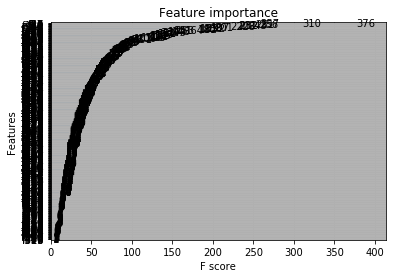

<Figure size 11520x7200 with 0 Axes>

In [28]:
xgb.plot_importance(xgb_model)
plt.figure(figsize = (160,100))
plt.show()

In [24]:
plo = xgb.to_graphviz(xgb_model)
plo.render('model_graph.gv')

'model_graph.gv.pdf'